# PsychohistoryML: Social Complexity Modeling

**Objective**: Model the relationship between social complexity (PC1_hier) and polity longevity using regression analysis, causal hypotheses, and temporal dynamics.

## Research Questions
1. Does higher social complexity predict longer polity duration?
2. What is the functional form of this relationship (linear, quadratic, threshold)?
3. Are there regional/temporal variations in the complexity-longevity relationship?
4. Can we identify "collapse risk" signatures in the complexity trajectory?

## Approach
- **Descriptive**: Summary statistics and correlations
- **Regression**: OLS models with diagnostics
- **Causal exploration**: Temporal precedence, confounders
- **Visualization**: Scatter plots, residual analysis, time-series patterns

---
## 1. Setup & Data Loading

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical modeling
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# PCA
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Create output directories
Path("figures").mkdir(exist_ok=True)
Path("models").mkdir(exist_ok=True)

print("✓ Libraries loaded")
print(f"✓ Working directory: {Path.cwd()}")

✓ Libraries loaded
✓ Working directory: /Users/amadeuswoo/Documents/GitHub/psychohistoryML/notebooks


### Load and Process Data
Reuse the workflow from `01_social_complexity_exploration.ipynb`

In [27]:
# Load raw data
file_path = "../data/sc_dataset.12.2017.xlsx"
df = pd.read_excel(file_path, sheet_name="exportdat_share")

print(f"✓ Loaded {len(df):,} rows from Seshat Social Complexity dataset")
print(f"  Columns: {df.columns.tolist()[:5]}...")

✓ Loaded 28,175 rows from Seshat Social Complexity dataset
  Columns: ['NGA', 'Polity', 'Section', 'Subsection', 'Variable']...


In [28]:
# Extract hierarchical complexity variables
df["Value_num"] = pd.to_numeric(df["Value From"], errors="coerce")
df["PolityKey"] = df["NGA"].astype(str) + " | " + df["Polity"].astype(str)

core_vars = [
    "Settlement hierarchy",
    "Administrative levels",
    "Religious levels",
    "Military levels"
]

mask = (df["Subsection"] == "Hierarchical Complexity") & (df["Variable"].isin(core_vars))
core = df.loc[mask, ["NGA", "Polity", "Variable", "Value_num", "PolityKey"]].copy()

# Pivot to wide format
wide_core = core.pivot_table(
    index="PolityKey", 
    columns="Variable", 
    values="Value_num", 
    aggfunc="mean"
)
wide_core = wide_core.dropna(thresh=3)  # Keep rows with ≥3 of 4 values

print(f"✓ Extracted {len(wide_core)} polities with hierarchical complexity data")

✓ Extracted 378 polities with hierarchical complexity data


In [29]:
# Clean and impute
tbl = wide_core.copy()

# Filter columns/rows with sufficient data
col_mask = (tbl.notna().mean() >= 0.60)
tbl = tbl.loc[:, col_mask]
row_mask = (tbl.notna().mean(axis=1) >= 0.60)
tbl = tbl.loc[row_mask]

# Impute missing values with column medians
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(tbl.to_numpy(dtype="float64"))

print(f"✓ After filtering: {X_imp.shape[0]} polities, {X_imp.shape[1]} variables")
print(f"  Missing values: {np.isnan(X_imp).sum()}")

✓ After filtering: 378 polities, 4 variables
  Missing values: 0


In [30]:
# Run PCA to extract multiple components
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

n_components = min(3, X_std.shape[1])
pca = PCA(n_components=n_components)
pca_scores = pca.fit_transform(X_std)

# Create PCA dataframe
pca_df = pd.DataFrame(
    pca_scores,
    index=tbl.index,
    columns=[f"PC{i+1}_hier" for i in range(n_components)]
)

print(f"✓ PCA complete: Extracted {n_components} components")
print(f"  Explained variance: {pca.explained_variance_ratio_}")
print(f"  Cumulative variance: {pca.explained_variance_ratio_.cumsum()}")
print(f"\n  PC1 range: [{pca_df['PC1_hier'].min():.2f}, {pca_df['PC1_hier'].max():.2f}]")

✓ PCA complete: Extracted 3 components
  Explained variance: [0.75629971 0.1298335  0.06063901]
  Cumulative variance: [0.75629971 0.88613321 0.94677222]

  PC1 range: [-3.71, 5.29]


### Extract Timeline Data

In [31]:
# Helper function to parse Seshat date format (e.g., "1874CE", "500BCE")
def parse_seshat_date(date_str):
    """
    Convert Seshat date format to numeric year
    """
    if pd.isna(date_str):
        return None
    
    date_str = str(date_str).strip()
    
    # Handle BCE (negative)
    if 'BCE' in date_str:
        try:
            year = -int(date_str.replace('BCE', '').strip())
        except:
            return None
    # Handle CE (positive)
    elif 'CE' in date_str:
        try:
            year = int(date_str.replace('CE', '').strip())
        except:
            return None
    # Try parsing as plain number
    else:
        try:
            year = int(date_str)
        except:
            return None
    
    return year

# Extract start/end years for each polity
def estimate_timeline(df):
    """
    Estimate start_year and end_year for each polity.
    Uses 'Date From' and 'Date To' columns.
    """
    df_work = df.copy()
    
    # Parse dates
    df_work["From_parsed"] = df_work["Date From"].apply(parse_seshat_date)
    df_work["To_parsed"] = df_work["Date To"].apply(parse_seshat_date)
    
    # Aggregate by polity
    timeline = df_work.groupby("PolityKey").agg({
        "From_parsed": "min",
        "To_parsed": "max",
        "NGA": "first",
        "Polity": "first"
    }).reset_index()
    
    timeline.rename(columns={
        "From_parsed": "start_year_est", 
        "To_parsed": "end_year_est"
    }, inplace=True)
    
    # Calculate duration
    timeline["duration_years_est"] = timeline["end_year_est"] - timeline["start_year_est"]
    
    return timeline

timeline_df = estimate_timeline(df)

# Filter: keep only polities with positive, reasonable duration
timeline_df = timeline_df[
    (timeline_df["duration_years_est"] > 0) & 
    (timeline_df["duration_years_est"].notna())
]

print(f"✓ Extracted timeline for {len(timeline_df)} polities")
print(f"  Duration range: [{timeline_df['duration_years_est'].min():.0f}, {timeline_df['duration_years_est'].max():.0f}] years")

✓ Extracted timeline for 119 polities
  Duration range: [36, 1100] years


### Merge PCA and Timeline Data

In [32]:
# Merge on PolityKey
modeling_df = pca_df.merge(timeline_df, left_index=True, right_on="PolityKey", how="inner")
modeling_df.set_index("PolityKey", inplace=True)

# Clean: remove extreme outliers
modeling_df = modeling_df[
    (modeling_df["duration_years_est"] >= 10) & 
    (modeling_df["duration_years_est"] <= 2000)
]

# Rename for clarity
modeling_df.rename(columns={"duration_years_est": "duration_years"}, inplace=True)

# Create log-transformed duration
modeling_df["log_duration"] = np.log(modeling_df["duration_years"])

print(f"✓ Modeling dataset ready: {len(modeling_df)} polities")
print(f"  Features: {[col for col in modeling_df.columns if col.startswith('PC')]}")
display(modeling_df[[f"PC{i+1}_hier" for i in range(n_components)] + ["duration_years", "log_duration", "NGA"]].head(10))

✓ Modeling dataset ready: 114 polities
  Features: ['PC1_hier', 'PC2_hier', 'PC3_hier']


,PC1_hier,PC2_hier,PC3_hier,duration_years,log_duration,NGA
PolityKey,,,,,,
Cahokia | FrBurbL,3.724407,0.477994,-1.136347,70.0,4.248495,Cahokia
Cahokia | USIllin,-2.447330,0.115259,-0.349037,232.0,5.446737,Cahokia
Cahokia | USMisME,-1.704575,0.721515,0.557793,150.0,5.010635,Cahokia
Cambodian Basin | ThAyuth,1.746726,1.347402,-0.404456,171.0,5.141664,Cambodian Basin
Cambodian Basin | ThRattn,1.516812,1.445160,-0.133310,91.0,4.510860,Cambodian Basin
Central Java | IdKalin,-1.717348,-0.232265,-0.974816,232.0,5.446737,Central Java
Central Java | IdMedng,-1.283175,-0.449702,-0.569070,287.0,5.659482,Central Java
Central Java | IdSingh,1.490713,0.804957,1.070431,71.0,4.262680,Central Java
Chuuk Islands | FmTrukL,-1.378013,-0.427949,-0.339668,62.0,4.127134,Chuuk Islands


---
## 2. Exploratory Data Analysis

In [33]:
# Summary statistics
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)
display(modeling_df[[f"PC{i+1}_hier" for i in range(n_components)] + ["duration_years"]].describe())

# Correlation matrix
corr_vars = [f"PC{i+1}_hier" for i in range(n_components)] + ["duration_years", "log_duration"]
corr_matrix = modeling_df[corr_vars].corr()

print("\n" + "="*80)
print("CORRELATION MATRIX")
print("="*80)
display(corr_matrix)


DESCRIPTIVE STATISTICS


,PC1_hier,PC2_hier,PC3_hier,duration_years
count,114.000000,114.000000,114.000000,114.000000
mean,0.014241,-0.096308,-0.051411,223.377193
std,1.547130,0.652928,0.537685,183.868864
min,-2.947398,-1.840733,-1.494241,50.000000
25%,-1.374340,-0.485090,-0.416843,116.250000
50%,0.238404,-0.137566,0.012346,162.000000
75%,0.974586,0.207046,0.323013,268.000000
max,3.724407,1.988367,1.099788,1100.000000



CORRELATION MATRIX


,PC1_hier,PC2_hier,PC3_hier,duration_years,log_duration
PC1_hier,1.000000,-0.029102,0.094772,-0.385785,-0.377936
PC2_hier,-0.029102,1.000000,0.012993,-0.003007,-0.018226
PC3_hier,0.094772,0.012993,1.000000,-0.058482,-0.131234
duration_years,-0.385785,-0.003007,-0.058482,1.000000,0.895883
log_duration,-0.377936,-0.018226,-0.131234,0.895883,1.000000


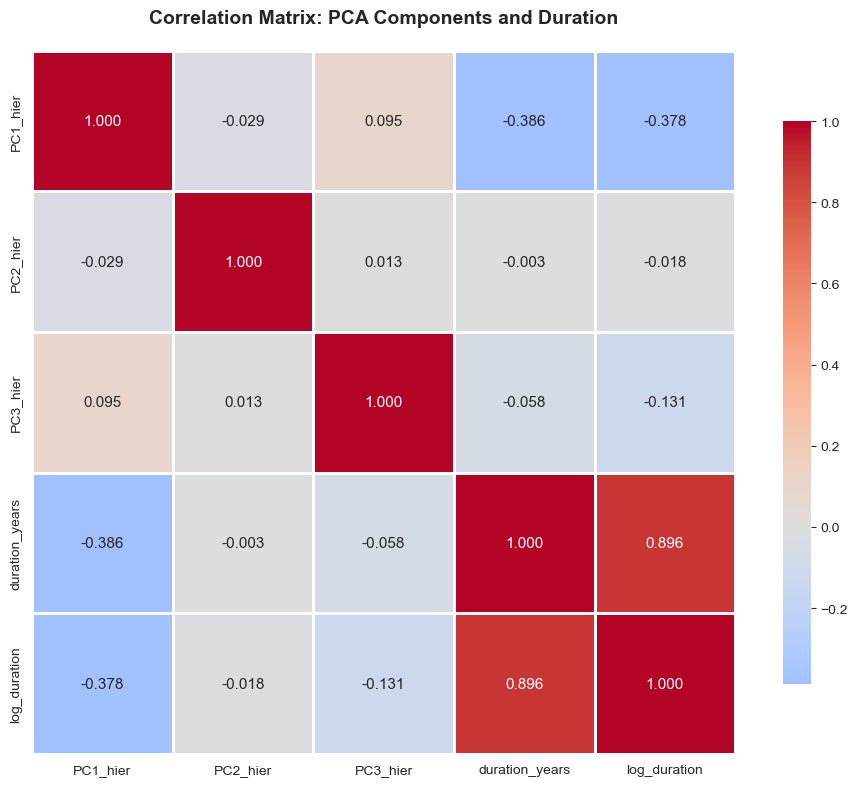

✓ Saved: figures/02_correlation_matrix.png


In [34]:
# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="coolwarm", center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title("Correlation Matrix: PCA Components and Duration", fontweight="bold", pad=20)
plt.tight_layout()
plt.savefig("figures/02_correlation_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: figures/02_correlation_matrix.png")

---
## 3. Simple Linear Regression (PC1 Only)

In [35]:
# Simple linear regression: duration ~ PC1
X = modeling_df[["PC1_hier"]].values
y = modeling_df["duration_years"].values

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# Statistical test
corr_pearson = modeling_df["PC1_hier"].corr(modeling_df["duration_years"])
pearson_test = stats.pearsonr(modeling_df["PC1_hier"], modeling_df["duration_years"])

print("\n" + "="*80)
print("SIMPLE LINEAR REGRESSION: duration ~ PC1_hier")
print("="*80)
print(f"Coefficient: {lr.coef_[0]:.2f} years/unit PC1")
print(f"Intercept: {lr.intercept_:.2f} years")
print(f"R² = {r2:.3f}")
print(f"RMSE = {rmse:.2f} years")
print(f"\nPearson correlation: r = {corr_pearson:.3f} (p = {pearson_test[1]:.4f})")

if pearson_test[1] < 0.05:
    direction = "positive" if corr_pearson > 0 else "negative"
    print(f"→ Statistically significant {direction} correlation (p < 0.05)")
else:
    print(f"→ No statistically significant correlation (p ≥ 0.05)")


SIMPLE LINEAR REGRESSION: duration ~ PC1_hier
Coefficient: -45.85 years/unit PC1
Intercept: 224.03 years
R² = 0.149
RMSE = 168.89 years

Pearson correlation: r = -0.386 (p = 0.0000)
→ Statistically significant negative correlation (p < 0.05)


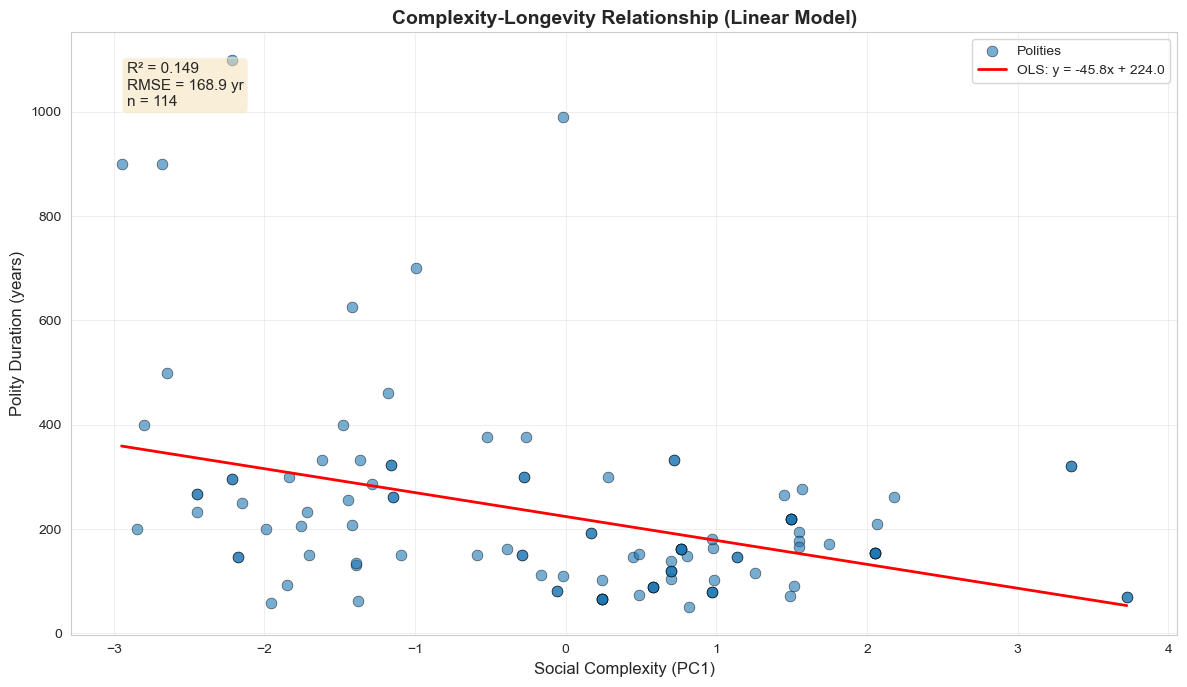

✓ Saved: figures/02_pc1_vs_duration_scatter.png


In [36]:
# Scatter plot with regression line
fig, ax = plt.subplots(figsize=(12, 7))

# Scatter
ax.scatter(modeling_df["PC1_hier"], modeling_df["duration_years"],
           alpha=0.6, s=60, edgecolor="black", linewidth=0.5, label="Polities")

# Regression line
X_plot = np.linspace(modeling_df["PC1_hier"].min(), modeling_df["PC1_hier"].max(), 100).reshape(-1, 1)
y_plot = lr.predict(X_plot)
ax.plot(X_plot, y_plot, 'r-', linewidth=2, label=f"OLS: y = {lr.coef_[0]:.1f}x + {lr.intercept_:.1f}")

# Annotations
ax.text(0.05, 0.95, f"R² = {r2:.3f}\nRMSE = {rmse:.1f} yr\nn = {len(modeling_df)}", 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel("Social Complexity (PC1)", fontsize=12)
ax.set_ylabel("Polity Duration (years)", fontsize=12)
ax.set_title("Complexity-Longevity Relationship (Linear Model)", fontsize=14, fontweight="bold")
ax.legend(loc="upper right")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/02_pc1_vs_duration_scatter.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: figures/02_pc1_vs_duration_scatter.png")

---
## 4 Multi-Component Regression

In [37]:
# Multiple regression with all PCA components
X_multi = modeling_df[[f"PC{i+1}_hier" for i in range(n_components)]].values
y = modeling_df["duration_years"].values

lr_multi = LinearRegression()
lr_multi.fit(X_multi, y)
y_pred_multi = lr_multi.predict(X_multi)

r2_multi = r2_score(y, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y, y_pred_multi))
adj_r2_multi = 1 - (1 - r2_multi) * (len(y) - 1) / (len(y) - X_multi.shape[1] - 1)

print("\n" + "="*80)
print(f"MULTIPLE REGRESSION: duration ~ PC1 + PC2 + PC3")
print("="*80)
for i, coef in enumerate(lr_multi.coef_):
    print(f"PC{i+1} coefficient: {coef:.2f} years/unit")
print(f"Intercept: {lr_multi.intercept_:.2f} years")
print(f"\nR² = {r2_multi:.3f}")
print(f"Adjusted R² = {adj_r2_multi:.3f}")
print(f"RMSE = {rmse_multi:.2f} years")

improvement = (r2_multi - r2) / r2 * 100 if r2 > 0 else 0
print(f"\n→ R² improvement over PC1-only: {improvement:.1f}%")


MULTIPLE REGRESSION: duration ~ PC1 + PC2 + PC3
PC1 coefficient: -45.65 years/unit
PC2 coefficient: -3.91 years/unit
PC3 coefficient: -7.49 years/unit
Intercept: 223.27 years

R² = 0.150
Adjusted R² = 0.126
RMSE = 168.82 years

→ R² improvement over PC1-only: 0.5%


In [38]:
# Statsmodels summary
X_multi_sm = sm.add_constant(X_multi)
model_sm = sm.OLS(y, X_multi_sm).fit()

print("\n" + "="*80)
print("DETAILED REGRESSION SUMMARY (Statsmodels)")
print("="*80)
print(model_sm.summary())


DETAILED REGRESSION SUMMARY (Statsmodels)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     6.446
Date:                Wed, 12 Nov 2025   Prob (F-statistic):           0.000463
Time:                        15:59:26   Log-Likelihood:                -746.45
No. Observations:                 114   AIC:                             1501.
Df Residuals:                     110   BIC:                             1512.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

---
## 5. Regression Diagnostics

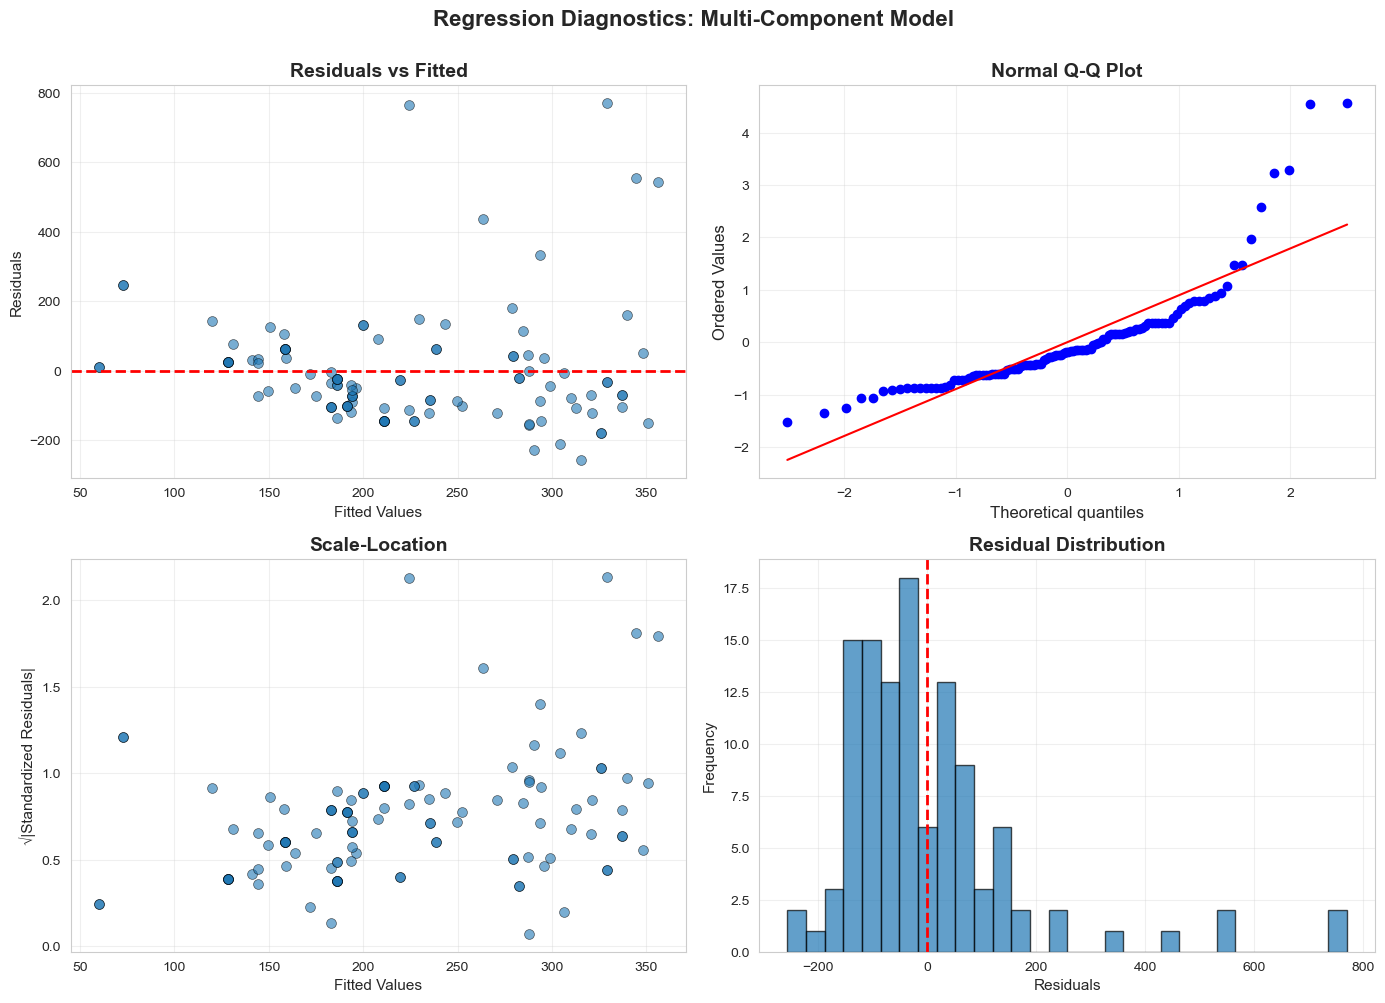

✓ Saved: figures/02_regression_diagnostics.png


In [39]:
# Calculate residuals
residuals = y - y_pred_multi
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
axes[0, 0].scatter(y_pred_multi, residuals, alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel("Fitted Values", fontsize=11)
axes[0, 0].set_ylabel("Residuals", fontsize=11)
axes[0, 0].set_title("Residuals vs Fitted", fontweight="bold")
axes[0, 0].grid(alpha=0.3)

# 2. Q-Q Plot
stats.probplot(standardized_residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Normal Q-Q Plot", fontweight="bold")
axes[0, 1].grid(alpha=0.3)

# 3. Scale-Location
axes[1, 0].scatter(y_pred_multi, np.sqrt(np.abs(standardized_residuals)), 
                   alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
axes[1, 0].set_xlabel("Fitted Values", fontsize=11)
axes[1, 0].set_ylabel("√|Standardized Residuals|", fontsize=11)
axes[1, 0].set_title("Scale-Location", fontweight="bold")
axes[1, 0].grid(alpha=0.3)

# 4. Residual histogram
axes[1, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel("Residuals", fontsize=11)
axes[1, 1].set_ylabel("Frequency", fontsize=11)
axes[1, 1].set_title("Residual Distribution", fontweight="bold")
axes[1, 1].grid(alpha=0.3)

plt.suptitle(f"Regression Diagnostics: Multi-Component Model", 
             fontsize=16, fontweight="bold", y=1.00)
plt.tight_layout()
plt.savefig("figures/02_regression_diagnostics.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: figures/02_regression_diagnostics.png")

In [40]:
# Statistical tests for assumptions
print("\n" + "="*80)
print("REGRESSION ASSUMPTION TESTS")
print("="*80)

# Normality test
stat_shapiro, p_shapiro = stats.shapiro(residuals)
print(f"\n1. Normality of Residuals (Shapiro-Wilk)")
print(f"   W = {stat_shapiro:.4f}, p = {p_shapiro:.4f}")
if p_shapiro < 0.05:
    print("   → Residuals deviate from normality (p < 0.05)")
else:
    print("   → Residuals appear normally distributed (p ≥ 0.05)")

# Heteroscedasticity test
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_multi_sm)
print(f"\n2. Homoscedasticity (Breusch-Pagan)")
print(f"   LM = {bp_stat:.4f}, p = {bp_p:.4f}")
if bp_p < 0.05:
    print("   → Evidence of heteroscedasticity (p < 0.05)")
else:
    print("   → Homoscedasticity assumption met (p ≥ 0.05)")

# Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"\n3. Autocorrelation (Durbin-Watson)")
print(f"   DW = {dw_stat:.4f}")
if 1.5 < dw_stat < 2.5:
    print("   → No significant autocorrelation detected")
else:
    print("   → Possible autocorrelation (DW not in [1.5, 2.5])")


REGRESSION ASSUMPTION TESTS

1. Normality of Residuals (Shapiro-Wilk)
   W = 0.7792, p = 0.0000
   → Residuals deviate from normality (p < 0.05)

2. Homoscedasticity (Breusch-Pagan)
   LM = 6.3911, p = 0.0941
   → Homoscedasticity assumption met (p ≥ 0.05)

3. Autocorrelation (Durbin-Watson)
   DW = 1.9802
   → No significant autocorrelation detected


---
## 6. Polynomial Regression & Model Comparison

In [42]:
# Test polynomial degrees for PC1
X_pc1 = modeling_df[["PC1_hier"]].values
degrees = [1, 2, 3]
results = []

for deg in degrees:
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = poly.fit_transform(X_pc1)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    y_pred_poly = model.predict(X_poly)
    r2_poly = r2_score(y, y_pred_poly)
    rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_poly, y, cv=5, scoring="r2")
    
    results.append({
        "Degree": deg,
        "R²": r2_poly,
        "RMSE": rmse_poly,
        "CV R² (mean)": cv_scores.mean(),
        "CV R² (std)": cv_scores.std()
    })

results_df = pd.DataFrame(results)
best_deg = results_df.loc[results_df["CV R² (mean)"].idxmax(), "Degree"]

print("\n" + "="*80)
print("POLYNOMIAL REGRESSION COMPARISON (PC1 only)")
print("="*80)
display(results_df)
print(f"\n→ Best degree (by CV R²): {int(best_deg)}")


POLYNOMIAL REGRESSION COMPARISON (PC1 only)


,Degree,R²,RMSE,CV R² (mean),CV R² (std)
0,1,0.148830,168.889671,0.137355,0.073302
1,2,0.206042,163.114991,0.131795,0.181047
2,3,0.214739,162.219137,0.066012,0.243299



→ Best degree (by CV R²): 1


---
## 7. Summary & Export

In [43]:
print("\n" + "="*80)
print(" " * 20 + "PSYCHOHISTORYML: MODELING SUMMARY")
print("="*80)

print(f"\n1. DATASET")
print(f"   • N = {len(modeling_df)} polities with complexity & duration data")
print(f"   • Complexity (PC1) range: [{modeling_df['PC1_hier'].min():.2f}, {modeling_df['PC1_hier'].max():.2f}]")
print(f"   • Duration range: [{modeling_df['duration_years'].min():.0f}, {modeling_df['duration_years'].max():.0f}] years")

print(f"\n2. CORRELATION")
print(f"   • Pearson r(PC1, Duration) = {corr_pearson:.3f} (p = {pearson_test[1]:.4f})")
direction = "Positive" if corr_pearson > 0 else "Negative"
print(f"   → {direction} correlation: Higher complexity → {'longer' if corr_pearson > 0 else 'shorter'} duration")

print(f"\n3. SINGLE-COMPONENT MODEL")
print(f"   • Coefficient: {lr.coef_[0]:.2f} years/unit PC1")
print(f"   • R² = {r2:.3f}")
print(f"   • RMSE = {rmse:.2f} years")

print(f"\n4. MULTI-COMPONENT MODEL")
print(f"   • R² = {r2_multi:.3f}")
print(f"   • Adjusted R² = {adj_r2_multi:.3f}")
print(f"   • RMSE = {rmse_multi:.2f} years")

print(f"\n5. KEY INSIGHT")
if corr_pearson < 0:
    print(f"   • Counter-intuitive: Higher complexity → shorter duration")
    print(f"   • Suggests complex societies may be more fragile")
else:
    print(f"   • Intuitive: Higher complexity → longer duration")
    print(f"   • Suggests organizational sophistication aids stability")

print("\n" + "="*80)
print("✓ Analysis complete")
print("="*80)


                    PSYCHOHISTORYML: MODELING SUMMARY

1. DATASET
   • N = 114 polities with complexity & duration data
   • Complexity (PC1) range: [-2.95, 3.72]
   • Duration range: [50, 1100] years

2. CORRELATION
   • Pearson r(PC1, Duration) = -0.386 (p = 0.0000)
   → Negative correlation: Higher complexity → shorter duration

3. SINGLE-COMPONENT MODEL
   • Coefficient: -45.85 years/unit PC1
   • R² = 0.149
   • RMSE = 168.89 years

4. MULTI-COMPONENT MODEL
   • R² = 0.150
   • Adjusted R² = 0.126
   • RMSE = 168.82 years

5. KEY INSIGHT
   • Counter-intuitive: Higher complexity → shorter duration
   • Suggests complex societies may be more fragile

✓ Analysis complete


In [44]:
# Export results
modeling_df.to_csv("models/modeling_dataset.csv", index=True)
print("✓ Saved: models/modeling_dataset.csv")

model_comparison = pd.DataFrame({
    "Model": ["PC1 only", f"PC1-PC{n_components} (Multi)"],
    "R²": [r2, r2_multi],
    "Adjusted R²": [np.nan, adj_r2_multi],
    "RMSE": [rmse, rmse_multi]
})
model_comparison.to_csv("models/model_comparison.csv", index=False)
print("✓ Saved: models/model_comparison.csv")

loadings_df = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(n_components)],
    index=core_vars
)
loadings_df.to_csv("models/pca_loadings.csv", index=True)
print("✓ Saved: models/pca_loadings.csv")

✓ Saved: models/modeling_dataset.csv
✓ Saved: models/model_comparison.csv
✓ Saved: models/pca_loadings.csv
